In [1]:
%load_ext rpy2.ipython
# Turning on in-IPy R capabilities

###This is the next step

In [2]:
%%R
library(phyloseq)
library(vegan)
library(plyr)
library(dplyr)
library(ggplot2)
library(picante)
library(ape)

/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: permute

  warnings.warn(x, RRuntimeWarning)
/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: lattice

  warnings.warn(x, RRuntimeWarning)
/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: This is vegan 2.4-1

  warnings.warn(x, RRuntimeWarning)
/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


  warnings.warn(x, RRuntimeWarning)
/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: The follo

../../SeqData/fulltree.tre
../../SeqData/otu_table.tax.meta.biom
../../SeqData/otus.pick.fasta

In [6]:
%%R
# Pulling in and converting the tree file to "phylo" format
MyTree = read.tree("../../SeqData/fulltree.tre")

In [22]:
%%R
Tips = MyTree$tip.label

In [24]:
%%R
NewTips = gsub('\'',"",Tips)
NewTips

In [26]:
%%R
MyTree$tip.label = gsub("\'","",MyTree$tip.label)

In [ ]:
%%R
# Tree tip labels have quotation marks in them that might be thwarting the nti calculator.


In [11]:
%%R
physeq = import_biom("../../../16S/SeqData/otu_table.tax.meta.biom", tree = "../../SeqData/fulltree.tre", parseFunction = parse_taxonomy_greengenes)

In [108]:
%%R
Merge<-paste(as.character(sample_data(physeq)$Trtmt),as.character(sample_data(physeq)$Month),as.character(sample_data(physeq)$Cosm),sep="_")
sample_data(physeq)$Merge <- Merge
# Creating a new column in the phyloseq sample data called Merge,
# which contains a concatenated ID so all samples from the same mineral, month, and cosm
# will have the same ID (thus merging PCR and buffer replicates).

ps.merged = merge_samples(physeq, "Merge")
# Merging the phyloseq object by biological replicates

keep=c("Cosm","Month","Trtmt")
sd = sample_data(ps.merged)
sd = sd[,keep]
sd$Trtmt = substring(row.names(sd),1,1)
sd$Trtmt[sd$Trtmt=="B"]="Blank"
sd$Trtmt[sd$Trtmt=="F"]="Ferrihydrite"
sd$Trtmt[sd$Trtmt=="Q"]="Quartz"
sd$Trtmt[sd$Trtmt=="H"]="Heavy Fraction"
sd$Trtmt[sd$Trtmt=="S"]="Soil"
sd$Trtmt[sd$Trtmt=="K"]="Kaolinite"
sample_data(ps.merged) = sd
physeq = ps.merged
physeq = subset_samples(physeq,sample_sums(physeq)>1500)

In [109]:
%%R
Comm = as.data.frame(otu_table(physeq))
# Takes the OTU table out of its physeq object and stores it as a data frame

In [27]:
%%R
#nri = ses.mpd(Comm[,-1],cophenetic(MyTree),null.model="taxa.labels",runs=10)
# Cophenetic takes the phylogenetic distances of the tree, and turns it into a distance matrix.
# 10 runs took <10 min.

In [110]:
%%R
nri100 = ses.mpd(Comm[,-1],cophenetic(MyTree),null.model="taxa.labels",runs=100)
write.csv(nri100,"../data/nri100.csv")
# Cophenetic takes the phylogenetic distances of the tree, and turns it into a distance matrix.

In [30]:
%%R
#nti = ses.mntd(Comm[,-1],cophenetic(MyTree),null.model="taxa.labels",runs=10)

In [111]:
%%R
nti100 = ses.mntd(Comm[,-1],cophenetic(MyTree),null.model="taxa.labels",runs=100)
write.csv(nti100,"../data/nti100.csv")

In [112]:
%%R
nti100$Sample = row.names(nti100)
NXI = merge(nti100,nri100)

In [113]:
%%R
row.names(NXI) = NXI$Sample
NXI$Trtmt = substr(NXI$Sample,1,1)
NXI
#Full dataset. Want to add back Q,F,K, etc.

                      ntaxa runs   mntd.obs mntd.rand.mean mntd.rand.sd
Quartz_2.5_30          1030  100 0.08287921     0.14498217 0.0032500327
Ferrihydrite_2_33      1059  100 0.08536862     0.14361566 0.0029876574
Quartz_2_33            1158  100 0.08446609     0.13847130 0.0028386550
Ferrihydrite_2.5_13    1162  100 0.08770017     0.13849138 0.0028240046
Kaolinite_3_23          120  100 0.19090717     0.30408107 0.0164119107
Ferrihydrite_3_44      1202  100 0.08324397     0.13651753 0.0028009680
Ferrihydrite_2_28      1278  100 0.08186272     0.13369247 0.0027746509
Kaolinite_2.5_16       1379  100 0.10455824     0.12973358 0.0026075818
Quartz_2.5_3           1464  100 0.08150318     0.12684624 0.0023617190
Soil_2.5_13            1527  100 0.07966316     0.12427782 0.0020127934
Ferrihydrite_2_9       1553  100 0.08468500     0.12388638 0.0024293132
Soil_2.5_16            1564  100 0.07858934     0.12370012 0.0020819879
Ferrihydrite_3_22      1570  100 0.08059866     0.12325575 0.002

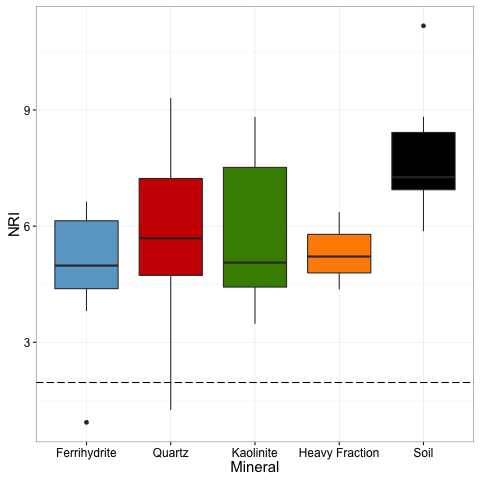

In [114]:
%%R
df = NXI
df = df %>%
    filter(Trtmt != "B")

df$Trtmt = ordered(df$Trtmt, levels = c("F", "Q", "K", "H", "S"))
df$Trtmt = revalue(df$Trtmt, c("F"="Ferrihydrite", "Q"="Quartz", "K"="Kaolinite", "H"="Heavy Fraction", "S"="Soil"))
p = ggplot(df, aes(x = Trtmt, y = -mpd.obs.z, fill = Trtmt))

p = p + geom_boxplot()

p = p + scale_fill_manual(values=c("skyblue3","red3","chartreuse4","darkorange","black","gold1"))

p = p + theme_bw()

p = p + guides(fill = "none")
p = p + theme(legend.position = "none")

p = p + theme(axis.text.x = element_text(size = 12),axis.text.y = element_text(size = 12))
p = p + theme(axis.title = element_text(size = 15))
p = p + geom_hline(yintercept = 1.96, linetype = "longdash")
p = p + labs(x="Mineral",y="NRI")

p

In [115]:
%%R
ggsave(filename="NRI.jpg", p, width=6, height=6)

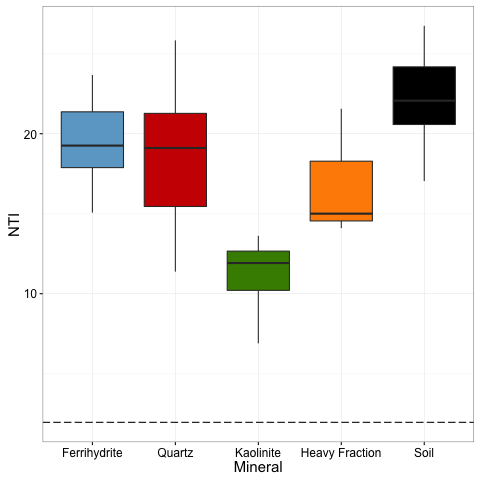

In [116]:
%%R
df = NXI
df = df %>%
    filter(Trtmt != "B")

df$Trtmt = ordered(df$Trtmt, levels = c("F", "Q", "K", "H", "S"))
df$Trtmt = revalue(df$Trtmt, c("F"="Ferrihydrite", "Q"="Quartz", "K"="Kaolinite", "H"="Heavy Fraction", "S"="Soil"))

p = ggplot(df, aes(x = Trtmt, y = -mntd.obs.z, fill = Trtmt))

p = p + geom_boxplot()

p = p + scale_fill_manual(values=c("skyblue3","red3","chartreuse4","darkorange","black","gold1"))

p = p + theme_bw()

p = p + guides(fill = "none")
p = p + theme(legend.position = "none")

p = p + theme(axis.text.x = element_text(size = 12),axis.text.y = element_text(size = 12))
p = p + theme(axis.title = element_text(size = 15))

p = p + geom_hline(yintercept = 1.96, linetype = "longdash")

p = p + labs(x="Mineral",y="NTI")

p

In [117]:
%%R
ggsave(filename="NTI.jpg", p, width=6, height=6)